# Resumen primera entrega

Este proyecto busca desarrollar un **modelo predictivo** para detectar transacciones fraudulentas con tarjetas de crédito, utilizando un dataset simulado que incluye información como montos, categorías de gasto y ubicaciones. La variable objetivo (*is_fraud*) clasifica las transacciones como fraudulentas (1) o no (0), planteando un problema de **clasificación binaria**. El análisis exploratorio (EDA) reveló que los fraudes son más comunes en montos bajos, en mujeres (aunque con montos menores) y en días como domingos, martes y jueves, especialmente durante la madrugada y la noche. Estas observaciones permiten proponer estrategias como monitoreo intensivo en horarios críticos y alertas en días clave. El objetivo final es implementar un modelo que ayude a las instituciones financieras a prevenir fraudes de manera eficiente.

# Proyecto Final

El problema de detección de fraude es un caso de **aprendizaje supervisado**, específicamente de **clasificación binaria**. El objetivo es entrenar un modelo que pueda predecir la clase correcta (fraude o no fraude) para nuevas transacciones.

El modelo de aprendisaje a utilizar va a ser **Random Forest** ya que combina múltiples árboles de decisión para mejorar la precisión y reducir el sobreajuste y es ideal para manejar datasets grandes y complejos, como este.



# Librerías

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

import os
import pandas               as pd
import matplotlib.pyplot    as plt
import seaborn              as sns

from sklearn.tree               import DecisionTreeClassifier
from sklearn.preprocessing      import LabelEncoder
from sklearn.model_selection    import train_test_split
from sklearn.ensemble           import RandomForestClassifier
from sklearn.metrics            import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection  import SelectKBest, f_classif

# Dataset

In [2]:
# %cd '/content/gdrive/MyDrive/Data Science I/Preentrega 1'

# carga del archivo CSV
# df = pd.read_csv('fraudTest.csv', sep=',')
df = pd.read_csv('../CSV/fraud.csv', sep=',')

df = df.drop(columns=['Unnamed: 0'])

# Variables Predictoras y Objetivo

In [17]:
X = df.drop(columns=['is_fraud'])  # Variables predictoras
y = df['is_fraud']  # Variable objetivo


#Seleccion de Variables

### Preparacion de los datos

In [18]:
# de string a datetime
X['trans_date_trans_time'] = pd.to_datetime(X['trans_date_trans_time'])

# dia de la semana (0 = lunes, 6 = domingo)
X['trans_day_of_week'] = X['trans_date_trans_time'].dt.dayofweek

# hora
X['trans_hour'] = X['trans_date_trans_time'].dt.hour

# de string a datetime
X['dob'] = pd.to_datetime(X['dob'], errors='coerce')

#fecha de  la transacion menos fecha de nacimiento = edad cuando se hizo la transaccion
X['age'] = (X['trans_date_trans_time'] - X['dob']).dt.days // 365


# elimino columnas innecesarias
cols_to_drop = ['first', 'last', 'street', 'city', 'state', 'job', 'trans_num', 'trans_date_trans_time','dob']
X = X.drop(columns=cols_to_drop, errors='ignore')

# variables con muchas categorias
high_cardinality_cols = ['merchant', 'category']
le = LabelEncoder()
for col in high_cardinality_cols:
    X[col] = le.fit_transform(X[col]) #transformadas a numeros

# variables con pocas categorias
low_cardinality_cols = ['gender']
X = pd.get_dummies(X, columns=low_cardinality_cols, drop_first=True) #one-hot encoding

# verificacion los tipos de datos
print(X.dtypes)

cc_num                 int64
merchant               int64
category               int64
amt                  float64
zip                    int64
lat                  float64
long                 float64
city_pop               int64
unix_time              int64
merch_lat            float64
merch_long           float64
trans_day_of_week      int32
trans_hour             int32
age                    int64
gender_M                bool
dtype: object


### SelectKBest

In [19]:
# eleccion de variables importantes
selector = SelectKBest(score_func=f_classif, k=10)  # 10 mejores caracteristicas
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()] # nombres de las variables
print("Caracteristicas seleccionadas:", selected_features)

Caracteristicas seleccionadas: Index(['category', 'amt', 'zip', 'lat', 'city_pop', 'unix_time', 'merch_lat',
       'trans_day_of_week', 'trans_hour', 'age'],
      dtype='object')


# Datos de entrenamiento y prueba

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, #variable pre seleccionadas
    y, # variable a pred3ecir
    test_size=0.2, # 80 entrenamiento / 20 prueba
    random_state=1234, #semilla
    stratify=y #los datos de fraude estan desbalanceados.
)

# Entrenamiento del modelo

## Random Forest

In [21]:
clf = RandomForestClassifier(
    n_estimators=100,  # n arboles
    max_depth=10,  # profundidad max
    random_state=1234
)
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X_train, y_train)

### Evaluacion del modelo

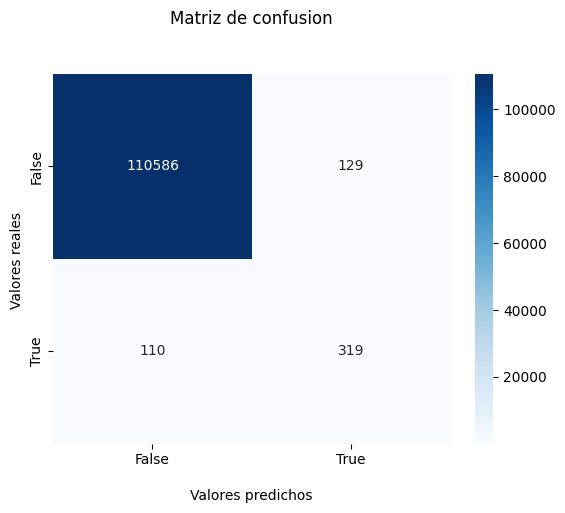


Accuracy: 0.9978496365075937

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110715
           1       0.71      0.74      0.73       429

    accuracy                           1.00    111144
   macro avg       0.86      0.87      0.86    111144
weighted avg       1.00      1.00      1.00    111144



In [22]:
predicciones = model.predict(X_test)

#Matriz de confusion
cf_matrix = confusion_matrix(y_test, predicciones)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
ax.set_title('Matriz de confusion\n\n')
ax.set_xlabel('\nValores predichos')
ax.set_ylabel('Valores reales ')
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

print("\nAccuracy:", accuracy_score(y_test, predicciones))

print("\nReporte de Clasificación:")
print(classification_report(y_test, predicciones))

In [23]:
clf = DecisionTreeClassifier(random_state=1234)
model2 = clf.fit(X_train, y_train)

# Visualicion de las Variables con Importancia

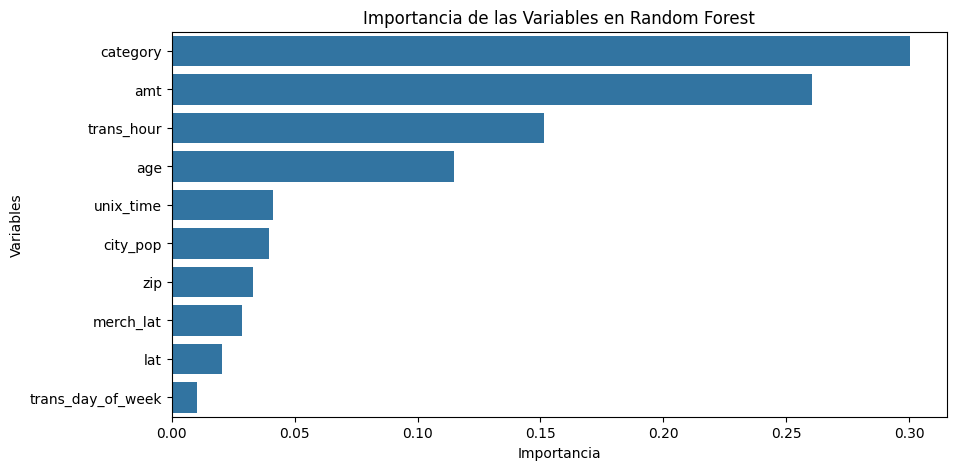

In [24]:
importances = model.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Variables": selected_features, "Importancia": importances}
).sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Importancia", y="Variables", data=feature_importance_df)
plt.title("Importancia de las Variables en Random Forest")
plt.show()

# Conclusiones

El modelo mostró un **accuracy** del 99.78%, lo que indica un alto nivel de precisión en la clasificación de transacciones. Sin embargo, al analizar la matriz de confusión y el reporte de clasificación, se observó que, el modelo es excelente para identificar transacciones no fraudulentas (clase 0) yno asi para la detección de fraudes (clase 1), con un **recall** del 74% y un **f1-score** del 73%, esto se debe al desbalance de clases, donde las transacciones fraudulentas representan menos del -1% del dataset.

El análisis de la importancia de las variables reveló que la categoría del comercio (category) y el monto de la transacción (amt) son los factores más determinantes para predecir fraudes, seguidos por la hora de la transacción (trans_hour) y la edad del titular (age). Estas variables respaldan los hallazgos del EDA y refuerzan la necesidad de enfocarse en estos aspectos para mejorar la detección de fraudes.

El modelo de **Random Forest** demostró ser efectivo para la detección de transacciones no fraudulentas, pero se requiere mejorar su capacidad para identificar fraudes. Futuros trabajos podrían incluir técnicas avanzadas de manejo de desbalance, como **SMOTE**.